
# Boosting

Boosting is an ensemble learning technique that combines multiple weak learners to create a strong learner. The main idea is to sequentially train models, where each new model focuses on correcting the errors made by the previous models. This iterative process allows boosting to improve the overall performance of the ensemble.

Boosting algorithms typically follow these steps:

1.  **Initialize Weights**: Start with equal weights for all training instances.
2.  **Train Weak Learner**: Train a weak learner (e.g., a decision stump) on the weighted training data.
3.  **Update Weights**: Increase the weights of misclassified instances and decrease the weights of correctly classified instances. This ensures that the next weak learner focuses more on the instances that were previously misclassified.
4.  **Combine Models**: Combine the predictions of all weak learners, often using a weighted sum where the weights are determined by the performance of each learner.
5.  **Repeat**: Repeat steps 2-4 for a specified number of iterations or until a stopping criterion is met (e.g., no significant improvement in performance).
6.  **Final Prediction**: The final prediction is made by combining the predictions of all weak learners, typically using a weighted majority vote for classification or a weighted average for regression.

## Advantages and Disadvantages

-   **Advantages**:
    -   Can significantly improve the performance of weak learners, often achieving state-of-the-art results.
    -   Focuses on difficult instances, allowing the model to learn complex patterns in the data.
    -   Can handle a wide range of base learners, including decision trees, linear models, and neural networks.
    -   Robust to overfitting, especially with regularization techniques like shrinkage (learning rate) and early stopping.
    -   Can be used for both classification and regression tasks.
-   **Disadvantages**:
    -   Sensitive to noisy data and outliers, as boosting focuses on correcting errors.
    -   Requires careful tuning of hyperparameters, such as the number of iterations, learning rate, and base learner complexity.
    -   Computationally expensive, especially with large datasets and complex base learners.

## Common Boosting Algorithms

-   **AdaBoost (Adaptive Boosting)**: One of the earliest and most popular boosting algorithms. It adjusts the weights of misclassified instances and combines weak learners in a weighted manner.
-   **Gradient Boosting**: Builds models sequentially, where each new model is trained to minimize the residual errors of the previous models. It can use various loss functions and is highly flexible.
-   **XGBoost (Extreme Gradient Boosting)**: An optimized version of gradient boosting that includes regularization techniques to prevent overfitting and improve performance. It is widely used in machine learning competitions.
-   **LightGBM**: A gradient boosting framework that uses a histogram-based approach to speed up training and reduce memory usage. It is particularly effective for large datasets.

## AdaBoost Overview

AdaBoost, short for Adaptive Boosting, is one of the earliest and most widely used boosting algorithms. It works by combining multiple weak classifiers to create a strong classifier. The key steps in AdaBoost are:

1.  **Initialize Weights**: Start with equal weights for all training instances.
2.  **Train Weak Learner**: Train a weak learner (e.g., a decision stump) on the weighted training data.
3.  **Update Weights**: Increase the weights of misclassified instances and decrease the weights of correctly classified instances. This ensures that the next weak learner focuses more on the instances that were previously misclassified.
4.  **Combine Models**: Combine the predictions of all weak learners, where each learner's contribution is weighted by its accuracy.
5.  **Repeat**: Repeat steps 2-4 for a specified number of iterations or until a stopping criterion is met (e.g., no significant improvement in performance).

### Example of AdaBoost

We will demonstrate AdaBoost using the titanic dataset, keeping only the `pclass`, `sex`, and `age` features. We will preprocess the data, train a single Decision Tree, and then use AdaBoost to improve the model's performance.

-   Load the titanic dataset

In [1]:
from sklearn import datasets

titanic = datasets.fetch_openml('titanic', version=1, as_frame=True)
df = titanic.frame[['pclass', 'sex', 'age', 'survived']]
X = df.drop(columns=['survived'])
y = df['survived'].astype('category').cat.codes
class_names = ['Not Survived', 'Survived']
feature_names = X.columns.tolist()
print(f"Feature names: {feature_names}")
print(f"Class labels: {class_names}")

Feature names: ['pclass', 'sex', 'age']
Class labels: ['Not Survived', 'Survived']


-   Train-test split

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

-   Create a preprocessing pipeline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('age', Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]
        ), ['age']),
        ('sex', Pipeline(
            steps=[
                ('encoder', OneHotEncoder(drop='first', sparse_output=False))
            ]
        ), ['sex']),
        ('pclass', Pipeline(
            steps=[
                ('enconder', OneHotEncoder(sparse_output=False))
            ]
        ), ['pclass'])
    ],
    remainder='passthrough'
)
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

feature_names = preprocessing_pipeline.get_feature_names_out()
print(f"Transformed feature names: {feature_names}")

Transformed feature names: ['age__age' 'sex__sex_male' 'pclass__pclass_1' 'pclass__pclass_2'
 'pclass__pclass_3']


-   Train a single Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dt_model = DecisionTreeClassifier(random_state=42)
grid_params = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(dt_model, grid_params, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_transformed, y_train)
print("Best parameters for Decision Tree:", grid_search.best_params_)

dt_model = grid_search.best_estimator_
dt_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters for Decision Tree: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


-   Evaluate the single Decision Tree model

Single Decision Tree Accuracy: 0.7990
              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       243
    Survived       0.74      0.72      0.73       150

    accuracy                           0.80       393
   macro avg       0.79      0.78      0.79       393
weighted avg       0.80      0.80      0.80       393



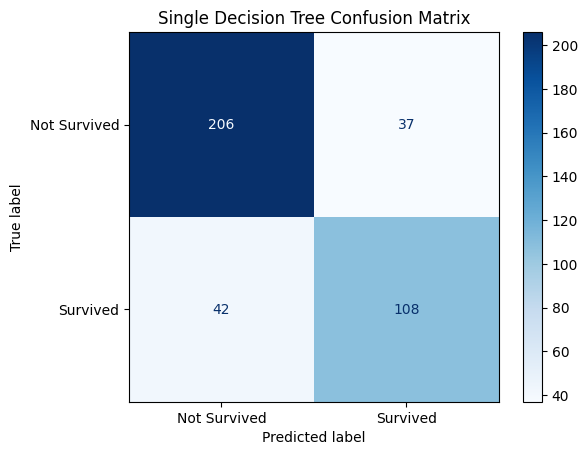

In [5]:
y_pred_dt = dt_model.predict(X_test_transformed)

print(f"Single Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt, target_names=class_names))
ConfusionMatrixDisplay.from_estimator(dt_model, X_test_transformed, y_test,
                                      display_labels=class_names, cmap='Blues')
plt.title('Single Decision Tree Confusion Matrix')
plt.show()

-   Train an AdaBoost Classifier

In [6]:
from sklearn.ensemble import AdaBoostClassifier
grid_params_ab = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [None, 2, 3, 4, 5],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}
grid_search_ab = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    grid_params_ab, cv=5, scoring='accuracy', verbose=1, n_jobs=-1
)
grid_search_ab.fit(X_train_transformed, y_train)
print(f"Best parameters for AdaBoost: {grid_search_ab.best_params_}")

ab_model = grid_search_ab.best_estimator_
ab_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters for AdaBoost: {'estimator__max_depth': 4, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 10, 'learning_rate': 0.01, 'n_estimators': 200}


,estimator,DecisionTreeC...ples_split=10)
,n_estimators,200
,learning_rate,0.01
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


-   Evaluate the AdaBoost model

AdaBoost Classifier Accuracy: 0.7990
              precision    recall  f1-score   support

Not Survived       0.83      0.86      0.84       243
    Survived       0.75      0.71      0.73       150

    accuracy                           0.80       393
   macro avg       0.79      0.78      0.78       393
weighted avg       0.80      0.80      0.80       393



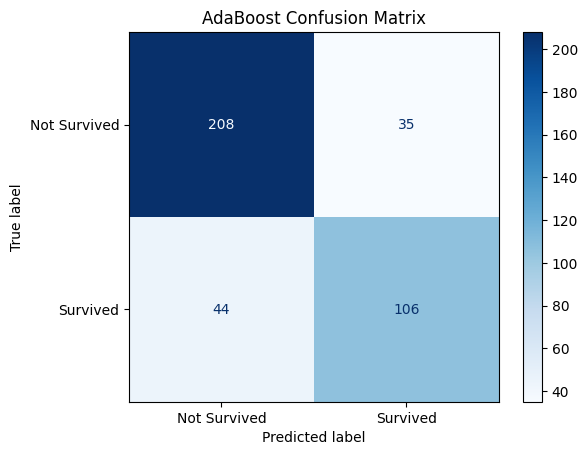

In [7]:
y_pred_ab = ab_model.predict(X_test_transformed)
print(f"AdaBoost Classifier Accuracy: {accuracy_score(y_test, y_pred_ab):.4f}")
print(classification_report(y_test, y_pred_ab, target_names=class_names))
ConfusionMatrixDisplay.from_estimator(ab_model, X_test_transformed, y_test,
                                      display_labels=class_names, cmap='Blues')
plt.title('AdaBoost Confusion Matrix')
plt.show()

-   Feature importance for AdaBoost

In [8]:
import pandas as pd
importances = ab_model.feature_importances_
indices = importances.argsort()[::-1]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances for AdaBoost:")
print(feature_importance_df)

Feature importances for AdaBoost:
            Feature  Importance
1     sex__sex_male    0.469367
0          age__age    0.202771
2  pclass__pclass_1    0.163301
4  pclass__pclass_3    0.151265
3  pclass__pclass_2    0.013297


-   Plot feature importances

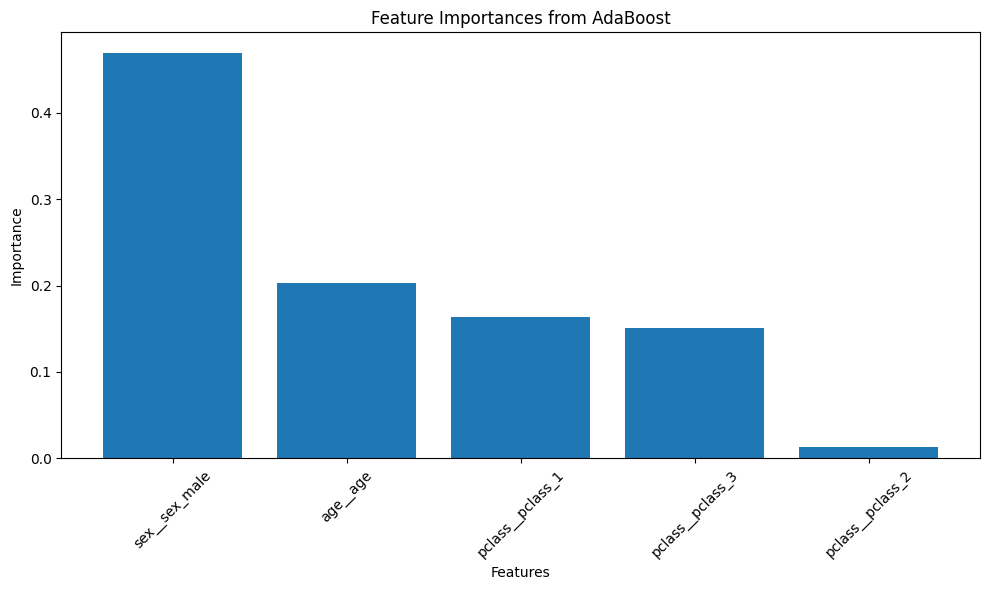

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_transformed.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_transformed.shape[1]), [feature_names[i] for i in indices],
           rotation=45)
plt.title('Feature Importances from AdaBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Gradient Boosting Overview

Gradient Boosting is a powerful ensemble learning technique that builds models sequentially, where each new model is trained to minimize the residual errors of the previous models. The key steps in Gradient Boosting are:

1.  **Initialize Model**: Start with a constant model (e.g., the mean of the target variable for regression).
2.  **Compute Residuals**: Calculate the residuals (errors) of the current model on the training data.
3.  **Train Weak Learner**: Train a weak learner (e.g., a decision tree) on the residuals, focusing on the instances where the current model performs poorly.
4.  **Update Model**: Add the predictions of the weak learner to the current model, scaled by a learning rate (shrinkage).
5.  **Repeat**: Repeat steps 2-4 for a specified number of iterations or until a stopping criterion is met (e.g., no significant improvement in performance).

### Example of Gradient Boosting

-   Train a Gradien Boosting Classifier

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
grid_params_gb = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
grid_search_gb = GridSearchCV(gb_model, grid_params_gb, cv=5, n_jobs=-1,
                              scoring='accuracy', verbose=1)
grid_search_gb.fit(X_train_transformed, y_train)
gb_model = grid_search_gb.best_estimator_
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
gb_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,50
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


-   Evaluate the Gradient Boosting Classifier

Gradient Boosting Classifier Accuracy: 0.8092
              precision    recall  f1-score   support

Not Survived       0.83      0.87      0.85       243
    Survived       0.77      0.71      0.74       150

    accuracy                           0.81       393
   macro avg       0.80      0.79      0.79       393
weighted avg       0.81      0.81      0.81       393



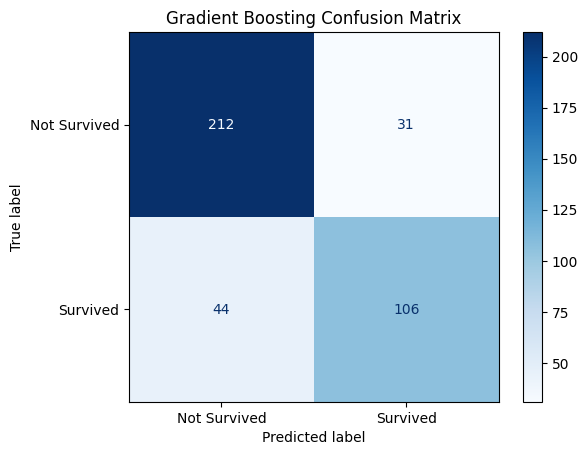

In [11]:
y_pred_gb = gb_model.predict(X_test_transformed)
print(f"Gradient Boosting Classifier Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb, target_names=class_names))
ConfusionMatrixDisplay.from_estimator(gb_model, X_test_transformed, y_test,
                                      display_labels=class_names, cmap='Blues')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

-   Feature importance for Gradient Boosting

Feature importances for Gradient Boosting:
            Feature  Importance
1     sex__sex_male    0.574131
0          age__age    0.227912
4  pclass__pclass_3    0.156952
2  pclass__pclass_1    0.035021
3  pclass__pclass_2    0.005983


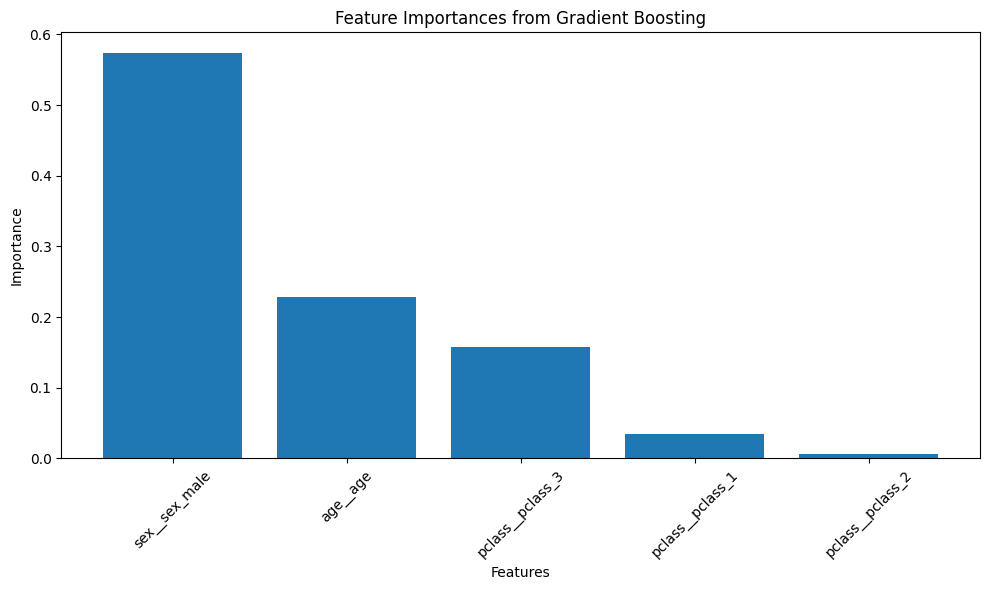

In [12]:
importances = gb_model.feature_importances_
indices = importances.argsort()[::-1]
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance',
                                                          ascending=False)
print("Feature importances for Gradient Boosting:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_transformed.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_transformed.shape[1]), [feature_names[i] for i in indices],
           rotation=45)
plt.title('Feature Importances from Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## XGBoost Overview

XGBoost, short for Extreme Gradient Boosting, is an optimized version of gradient boosting that includes regularization techniques to prevent overfitting and improve performance. It is widely used in machine learning competitions and real-world applications. The key features of XGBoost include:

-   **Regularization**: XGBoost includes L1 (Lasso) and L2 (Ridge) regularization to control model complexity and prevent overfitting.
-   **Tree Pruning**: XGBoost uses a depth-first approach to grow trees and prunes them based on a minimum loss reduction criterion, which helps in building more efficient models.
-   **Parallelization**: XGBoost can parallelize the tree construction process, making it faster than traditional gradient boosting methods.

### Example of XGBoost

-   Train a XGBoost Classifier

In [13]:
from xgboost import XGBClassifier

# XGBoost Classifier
grid_params_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    grid_params_xgb, cv=5, n_jobs=-1, scoring='accuracy', verbose=1
)
grid_search_xgb.fit(X_train_transformed, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
xgb_model = grid_search_xgb.best_estimator_
xgb_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


-   Evaluate the XGBoost Classifier

XGBoost Classifier Accuracy: 0.8168
              precision    recall  f1-score   support

Not Survived       0.84      0.87      0.85       243
    Survived       0.78      0.73      0.75       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.80       393
weighted avg       0.82      0.82      0.82       393



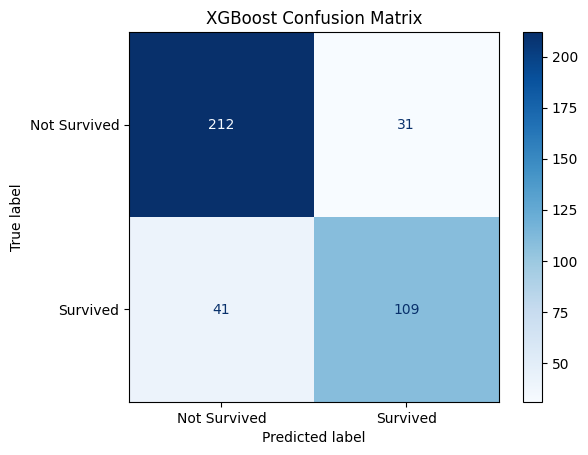

Feature importances for XGBoost:
            Feature  Importance
1     sex__sex_male    0.661201
4  pclass__pclass_3    0.226911
2  pclass__pclass_1    0.055751
0          age__age    0.030057
3  pclass__pclass_2    0.026079


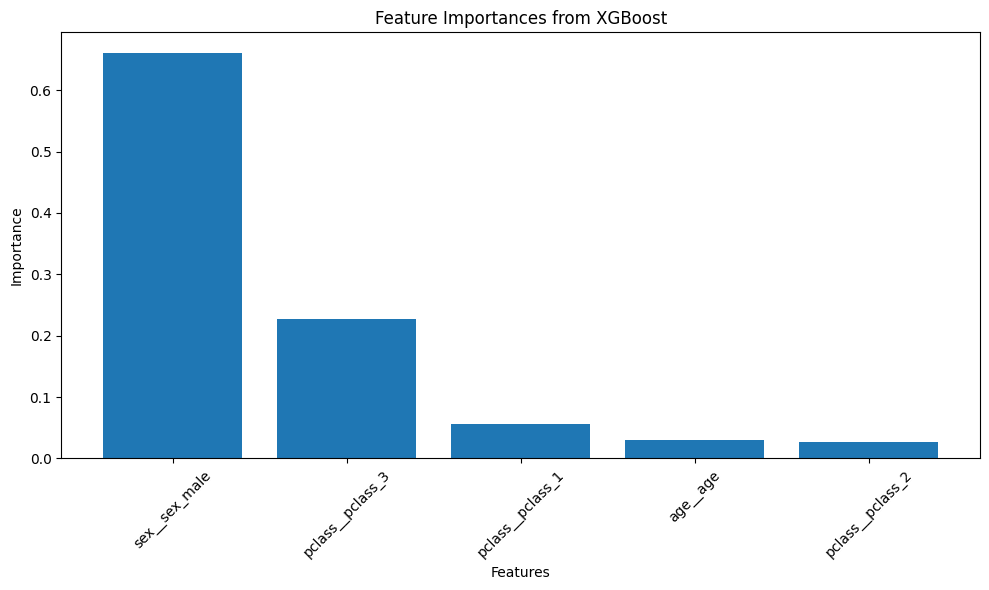

In [14]:
y_pred_xgb = xgb_model.predict(X_test_transformed)
print(f"XGBoost Classifier Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb, target_names=class_names))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_transformed, y_test,
                                        display_labels=class_names, cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Feature importance for XGBoost
import pandas as pd
importances = xgb_model.feature_importances_
indices = importances.argsort()[::-1]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances for XGBoost:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_transformed.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_transformed.shape[1]), [feature_names[i] for i in indices],
           rotation=45)
plt.title('Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Hands-on Exercise

-   Implement a boosting algorithm of your choice (AdaBoost, Gradient Boosting, or XGBoost) on the `house_prices` dataset.

In [15]:
# Load the house_prices dataset
from sklearn.datasets import fetch_openml
house_prices = fetch_openml('house_prices', version=1, as_frame=True)
df = house_prices.frame

In [16]:
# Check whether the dataset has missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [17]:
# Select relevant features and target variable
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing pipeline
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), X.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough'
  )

X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [18]:
# Train a Support Vector Regressor
from sklearn.svm import SVR
grid_params_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}
grid_search_svr = GridSearchCV(
    SVR(), grid_params_svr, cv=5, n_jobs=-1, scoring='r2', verbose=1
)
grid_search_svr.fit(X_train_transformed, y_train)
print("Best parameters for Support Vector Regressor:", grid_search_svr.best_params_)
svr_model = grid_search_svr.best_estimator_
svr_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Support Vector Regressor: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}


,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,10
,epsilon,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [19]:
# Evaluate the SVR
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
y_pred_svr = svr_model.predict(X_test_transformed)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"Support Vector Regressor RMSE: {rmse_svr:.4f}")
print(f"Support Vector Regressor R^2: {r2_svr:.4f}")

Support Vector Regressor RMSE: 51669.9132
Support Vector Regressor R^2: 0.6174


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
# XGBoost Regressor
grid_params_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(
    XGBRegressor(random_state=42, eval_metric='rmse'),
    grid_params_xgb, cv=5, n_jobs=-1, scoring='r2', verbose=1
)
grid_search_xgb.fit(X_train_transformed, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
xgb_model = grid_search_xgb.best_estimator_
xgb_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 1.0}


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


XGBoost Regressor RMSE: 25782.8259
XGBoost Regressor R^2: 0.9047
Feature importances for XGBoost:
                   Feature  Importance
4         num__OverallQual    0.189638
244  cat__GarageFinish_Unf    0.075611
179       cat__BsmtQual_Ex    0.072828
26         num__GarageCars    0.061467
223    cat__KitchenQual_TA    0.057392


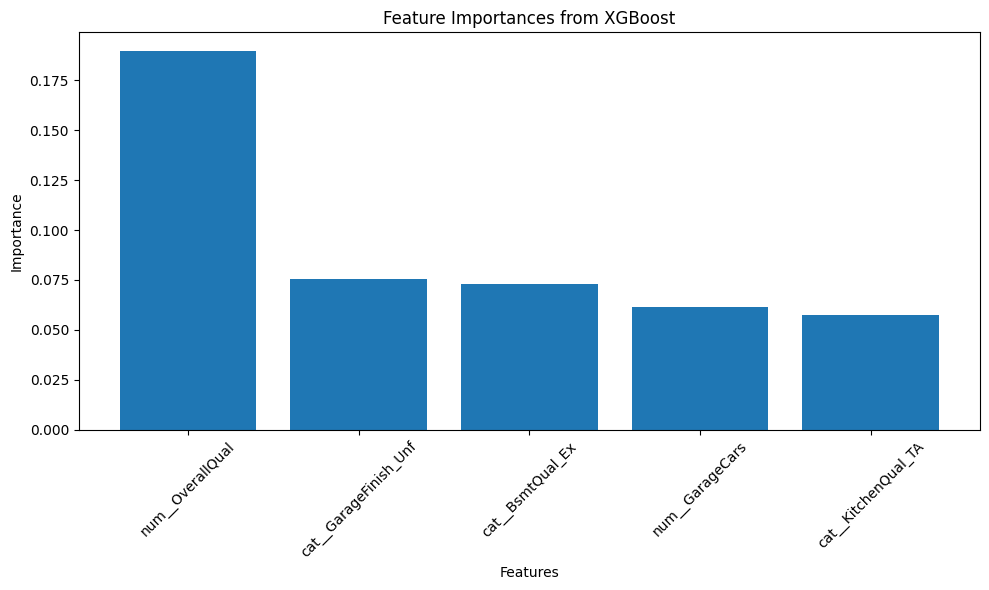

In [21]:
# Evaluate the XGBoost Regressor
y_pred_xgb = xgb_model.predict(X_test_transformed)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Regressor RMSE: {rmse:.4f}")
print(f"XGBoost Regressor R^2: {r2:.4f}")

# Feature importance for XGBoost
importances = xgb_model.feature_importances_
indices = importances.argsort()[::-1]
feature_importance_df = pd.DataFrame({'Feature': preprocessing_pipeline.get_feature_names_out(),
                                      'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances for XGBoost:")
print(feature_importance_df[:5])

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(5), importances[indices[:5]], align='center')
plt.xticks(range(5),
           [preprocessing_pipeline.get_feature_names_out()[i] for i in indices[:5]],
           rotation=45)
plt.title('Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()